# Week 7 - Temporal models 

## Part 3: Road traffic - Time-series imputation

In this part, we will specify a simple linear dynamical system (LDS) in Pyro in order to do **imputation** on the freeway occupancy rates. Time-series imputation, and imputation of missing values in general, is a problem that arises very frequently when dealing with real data from real-world problems. 

There exist many imputation techniques in the literature, but here we will consider model-based approaches. Since we have a probabilistic model for our problem, all we need to do is to treat the missing observations as latent variables in the model and do inference on them - this is the Bayesian way! (and arguably the best way of properly doing imputation... :-) ) This is because the Bayesian framework provide us with a coherent way for handling missing observations.

The usual imports...

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import time

import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

c:\Users\jakob\anaconda3\envs\my_environment\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The data consists of time-series of freeway occupancy rates (rows), with length $T=1008$, at 10 different consecutive sensors/detectors (columns). Although we will focus only on the data from a single detector as an example...

Load data:

In [2]:
df = pd.read_csv("http://mlsm.man.dtu.dk/mbml/PeMS_sample.csv")
df.head()

,# detector400000,detector400001,detector400009,detector400010,detector400015,detector400017,detector400025,detector400026,detector400027,detector400030
0,0.0154,0.0054,0.0164,0.0079,0.0059,0.0138,0.0111,0.0156,0.0154,0.0080
1,0.0085,0.0051,0.0127,0.0062,0.0051,0.0125,0.0099,0.0175,0.0134,0.0067
2,0.0099,0.0056,0.0172,0.0068,0.0053,0.0116,0.0105,0.0157,0.0112,0.0065
3,0.0108,0.0045,0.0126,0.0072,0.0058,0.0131,0.0073,0.0146,0.0128,0.0040
4,0.0100,0.0037,0.0185,0.0048,0.0063,0.0099,0.0061,0.0157,0.0123,0.0064


Some basic data statistics:

In [3]:
print("Dataset size:", len(df))
print("General statistics:")
df.describe()

Dataset size: 1008
General statistics:


,# detector400000,detector400001,detector400009,detector400010,detector400015,detector400017,detector400025,detector400026,detector400027,detector400030
count,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.00000,1008.000000
mean,0.049489,0.044541,0.066207,0.051599,0.026812,0.047976,0.037051,0.055881,0.05583,0.049262
std,0.030016,0.047490,0.047321,0.040934,0.019402,0.052455,0.036248,0.049275,0.04192,0.042152
min,0.005300,0.000000,0.000000,0.000000,0.001900,0.002200,0.002900,0.002500,0.00150,0.001500
25%,0.027150,0.014900,0.029525,0.018000,0.013100,0.014775,0.012075,0.017950,0.01820,0.027075
50%,0.055300,0.038600,0.070500,0.046400,0.021700,0.038750,0.029000,0.051500,0.05665,0.046700
75%,0.064400,0.051900,0.088025,0.070800,0.030925,0.054125,0.045400,0.069825,0.07670,0.058925
max,0.317600,0.355000,0.393600,0.232700,0.094900,0.316900,0.197200,0.307400,0.22060,0.408100


Visualize data (part of it):

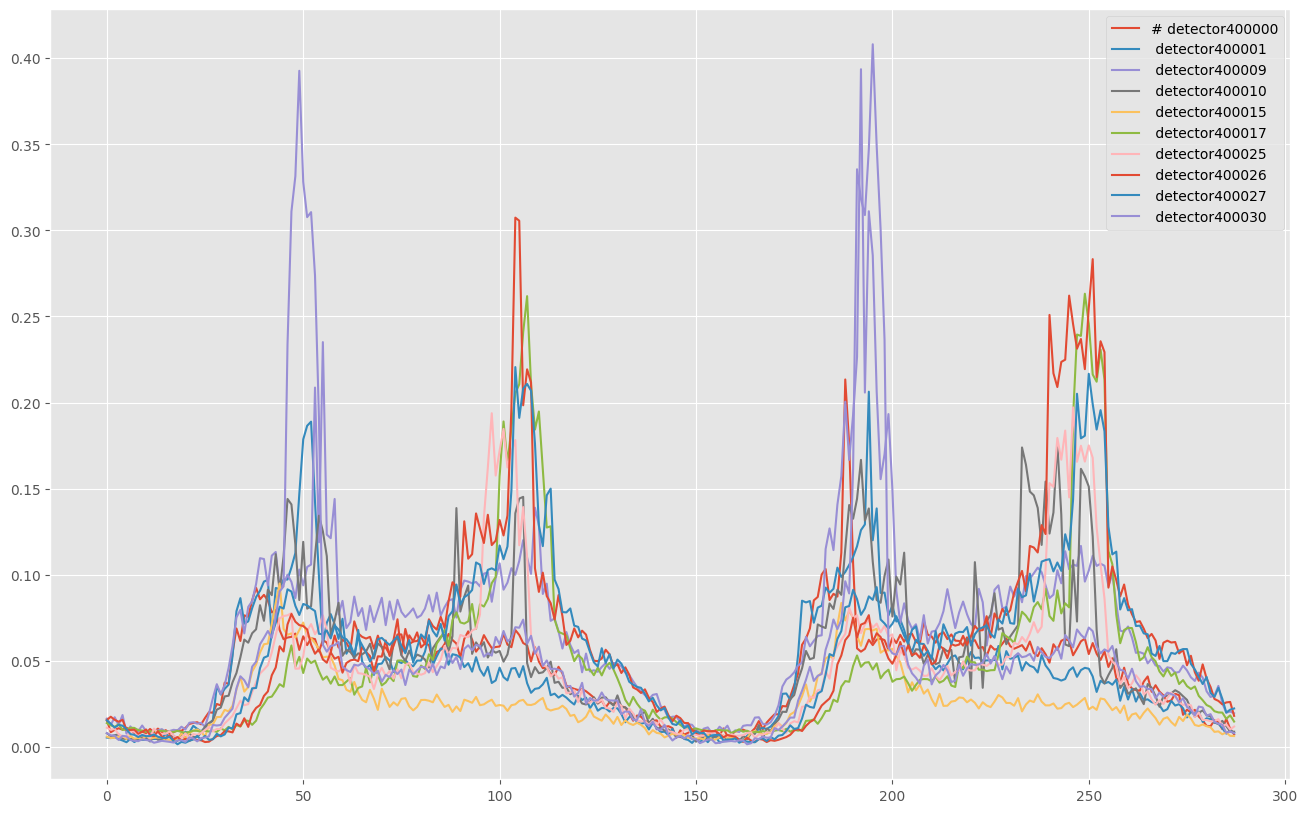

In [4]:
plt.plot(df[:(2*24*6)]) # first 2 days (2*24*6 10-minute intervals) of each of the 10 detectors
plt.legend(df.columns);

Lets now generate some articial missing data at random. To make things challenging, will consider a difficult setting were **80% of the observations are missing**. 

Notice that we save the real observations for the 80% missings, in order to evaluate the accuracy of our imputations later on.

In [5]:
# convert data to a matrix
y = df.values
y = y[:(6*24*1)]
N, D = y.shape
print("N=%d, D=%d" % (N,D))

N=144, D=10


In [6]:
missing_perc = 0.8 # missing percentage

perm1 = np.random.permutation(N)
ix_mis1 = perm1[:int(missing_perc * N)] # missing indexes
ix_obs1 = perm1[int(missing_perc * N):] # observed indexes
y_mis1 = y[ix_mis1,7] #Using data in column 7 (ID=detector400026)
y_obs1 = y[ix_obs1,7]  

N_obs = len(ix_obs1)
N_mis = len(ix_mis1)
N = N_obs + N_mis
print("N_obs:", N_obs)
print("N_mis:", N_mis)

N_obs: 29
N_mis: 115


Ok, time to go to Pyro!

Implementing imputation in Pyro requires you to notice that you must tell Pyro which observations are missings so that we can use `numpyro.sample` statement, and let Pyro compute their posterior distribution (inference). In a way, this is similar to what we did in the forecasting notebook, where we told Pyro that there exist these extra "T_forecast" variables, `z_collection[T:T_forecast]`,which follow the same dynamics as the previous z's, and that Pyro should do inference on them (remember, this is done by specifying `numpyro.sample` with `obs=None`).

In the case of time-series imputation, we will do the following:
-  Besides the observed values (y_obs), we will pass Pyro two arrays: one with the indexes of the time-series that are observed (ix_obs), and another with missing indexes (ix_mis).
- Amongst the `numpyro.sample` statements, we need to specify which variables we want Pyro to do inference on. Therefore, this block must include, among others, an array "y_mis" with the missing observations from the time-series.

For the purpose of demonstration, we will use a simple autoregressive model of order 1, AR(1), of the form:

\begin{align}
z_t &\sim \mathcal{N}(\beta z_{t-1}, \tau^2)\\
y_t &\sim \mathcal{N}(z_t, \sigma^2)
\end{align}

Now, it is your turn! As for the previous notebook, we provide you the `f` function for the `jax.lax.scan` method. Can you write the Pyro program? We know it is an intimidating task at first, so do not hesitate to ask questions and clarifications! :-)

In [8]:
def f(carry, noise_t):
  beta, z_prev, tau = carry
  z_t = beta*z_prev + tau*noise_t
  z_prev = z_t
  return (beta, z_prev, tau), z_t

In [9]:
def model(T, T_forecast, obs=None, ix_mis=None, ix_obs=None):
    """
    Define priors over beta, tau, noises, sigma, z_1 (keep the shapes in mind)
    """
    # TODO: Your code here

    """
    Propagate the dynamics forward using jax.lax.scan
    """
    # TODO: Your code here
    """
    Sample the observed y (y_obs) and missing y (y_mis)
    """
    # TODO: Your code here

Run inference using MCMC:

In [10]:
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=N, T_forecast=0, obs=y[:,7], ix_mis=ix_mis1, ix_obs=ix_obs1)

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

sample: 100%|██████████| 2000/2000 [00:45<00:00, 44.11it/s, 1023 steps of size 2.96e-03. acc. prob=0.99] 


Total time: 0.927m


In [11]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       beta      0.98      0.02      0.98      0.96      1.01    180.64      1.00
  noises[0]      0.03      1.02      0.10     -1.61      1.72    442.09      1.00
  noises[1]     -0.02      0.90     -0.03     -1.48      1.44    498.61      1.00
  noises[2]     -0.06      0.95     -0.06     -1.60      1.50    388.18      1.00
  noises[3]      0.01      0.99      0.03     -1.61      1.59    426.63      1.00
  noises[4]     -0.03      0.99     -0.05     -1.54      1.68    422.42      1.01
  noises[5]     -0.09      0.97     -0.12     -1.82      1.40    381.12      1.00
  noises[6]     -0.03      0.96     -0.02     -1.50      1.74    607.32      1.00
  noises[7]     -0.09      0.99     -0.07     -1.74      1.50    485.62      1.00
  noises[8]      0.01      1.00      0.01     -1.47      1.80    554.84      1.00
  noises[9]      0.03      0.99      0.03     -1.60      1.60    562.17      1.00
 noises[10]    

Extract samples and plot posteriors over some of the latent variables (parameters): beta, tau and sigma

In [12]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

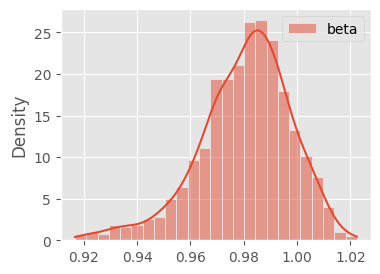

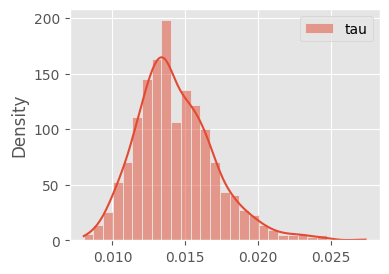

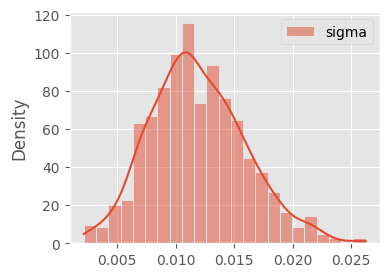

In [13]:
nodes = ["beta", "tau", "sigma"]
for node in nodes:
  plt.figure(figsize=(4,3))
  sns.histplot(hmc_samples[node], label=node, kde=True, stat="density")
  plt.legend()
  plt.show()

Compute mean and standard devitions for the imputed values of the time-series and visualize them (in comparison with the corresponding true values):

In [14]:
# get mean and standard devitions for predictions
y_hat = hmc_samples["y_mis"].mean(axis=0)
y_std = hmc_samples["y_mis"].std(axis=0)

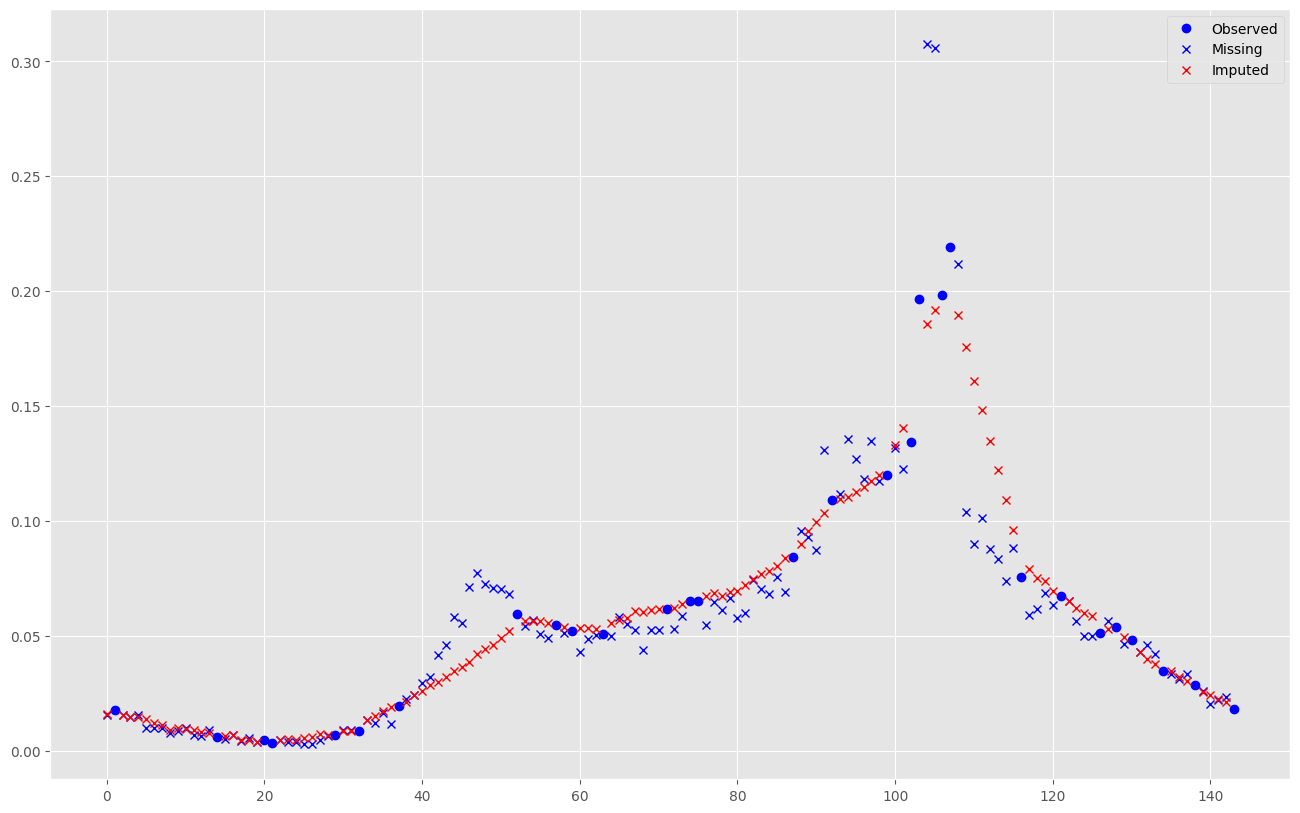

In [15]:
plt.plot(ix_obs1, y_obs1, "bo")
plt.plot(ix_mis1, y_mis1, "bx")
plt.plot(ix_mis1, y_hat, "rx")
plt.legend(["Observed", "Missing", "Imputed"]);

Compute error statistics of the model's imputations:

In [16]:
def compute_error(trues, predicted):
    import numpy
    corr = numpy.corrcoef(predicted, trues)[0,1]
    mae = numpy.mean(np.abs(predicted - trues))
    rae = numpy.sum(numpy.abs(predicted - trues)) / numpy.sum(numpy.abs(trues - numpy.mean(trues)))
    rmse = numpy.sqrt(numpy.mean((predicted - trues)**2))
    r2 = max(0, 1 - numpy.sum((trues-predicted)**2) / numpy.sum((trues - numpy.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [17]:
corr, mae, rae, rmse, r2 = compute_error(y_mis1, y_hat)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.897
MAE: 0.01107
RMSE: 0.02219
R2: 0.805


*Not* too bad... But our model was quite naive. We can definitely do better with a more appropriate model, i.e. that exploits our prior knowledge about this particular problem. That is what we shall do in the next notebook! :-)